# Feature Extraction


## Load data
The five outputs of preprocessing are imported:
1. 'data/prepped.pkl' is a pickled dataframe containing cleaned comments and their subreddit label
2. 'data/feature_names.pkl' is a pickled series containing the words that were counted
3. 'data/term_counts.npz' is a scipy sparse matrix containing the word counts
4. 'data/tf.npz' is a scipy sparse matrix containing the word frequencies
5. 'data/tf.npz' is a scipy sparse matrix containing the word frequencies weighted by their inverse document frequency

In [2]:
import numpy as np
import pandas as pd
from time import time
from scipy.sparse import load_npz
import pickle

print("Importing data...")
t0 = time()
data = pd.read_pickle('data/prepped.pkl')
with open('data/feature_names.pkl', 'rb') as fp:
    feature_names = pickle.load(fp)
cts = load_npz('data/term_counts.npz')
tf = load_npz('data/tf.npz')
tfidf = load_npz('data/tfidf.npz')
print("done in %0.3fs" % (time()-t0))


Importing data...
done in 6.899s


## Classification
In order to compare feature extraction methods using a gold standard, we formulate a classification problem against each comments' subreddit.

### Cross-validation
Twenty percent of the data is left out for cross-validation, with class balances kept intact as best as possible.

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# X = data['body'].astype('unicode')
# X = cts
# X = tf
X = tfidf

le = LabelEncoder()
y = le.fit_transform(data.subreddit.iloc)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)


### Compute word frequency matrix decompositions on training data

In [10]:
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation

n_samples  = tfidf.shape[0]
n_features = tfidf.shape[1]
n_components = 10 # new number of features

print("Fitting LSA model")
t0 = time()
LSA_model = TruncatedSVD(n_components=n_components, random_state=0).fit(X_train)
LSA_train = LSA_model.transform(X_train)
LSA_test  = LSA_model.transform(X_test)
print("done in %0.3fs." % (time() - t0))
print()

print("Fitting pLSA model")
# Use the non-negative matrix factorization with generalized Kullback-Leibler divergence
t0 = time()
pLSA_model = NMF(n_components=n_components, random_state=0,
                 beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
                 l1_ratio=.5).fit(X_train)
pLSA_train = pLSA_model.transform(X_train)
pLSA_test  = pLSA_model.transform(X_test)
print("done in %0.3fs." % (time() - t0))
print()

print("Fitting LDA model")
t0 = time()
LDA_model = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method='online',
                                learning_offset=50,
                                random_state=0).fit(X_train)
LDA_train = LDA_model.transform(X_train)
LDA_test  = LDA_model.transform(X_test)
print("done in %0.3fs." % (time() - t0))
print()


Fitting LSA model
        fitting in 1.136s.
train transform in 0.015s.
 test transform in 0.011s.
done in 1.162s.
Fitting pLSA model
        fitting in 21.290s.
train transform in 1.834s.
 test transform in 0.621s.
done in 23.746s.
Fitting LDA model
        fitting in 172.514s.
train transform in 0.675s.
 test transform in 0.207s.
done in 173.397s.


### Test feature extractors using various classifiers

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

extractors = [
    ("LSA", LSA_train, LSA_test),
    ("pLSA", pLSA_train, pLSA_test),
    ("LDA", LDA_train, LDA_test)
    ]

classifiers = [
    ("Nearest Neighbors", KNeighborsClassifier(3)),
    #("Linear SVM", SVC(kernel="linear", C=0.025)),
    #("RBF SVM", SVC(gamma=2, C=1)),
    #("Decision Tree", DecisionTreeClassifier(max_depth=5)),
    ("Random Forest", RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)),
    #("AdaBoost", AdaBoostClassifier()),
    ("Naive Bayes", GaussianNB()),
    #("QDA", QuadraticDiscriminantAnalysis())
    ]

for ex_name, ex_train, ex_test in extractors:
    print("%s" % ex_name)
    print()
    for cl_name, clf in classifiers:
        print("   %s" % cl_name)
        
        t0 = time()
        clf.fit(ex_train, y_train)
        t1 = time()
        score = clf.score(ex_test, y_test)
        t2 = time()
        train_score = clf.score(ex_train, y_train)
        
        print("           Train")
        print("   Train time: %0.3f sec" % (t1-t0))
        print("   Accuracy  : %0.2f %%" % (100*train_score))
        print("   Acc. mult.: %0.2f" % (train_score*(y.max()-y.min()+1)))
        print("           Test")
        print("   Score time: %0.3f sec" % (t2-t1))
        print("   Accuracy  : %0.2f %%" % (100*score))
        print("   Acc. mult.: %0.2f" % (score*(y.max()-y.min()+1)))
        print()
    

LSA

   Nearest Neighbors
           Train
   Train time: 0.027 sec
   Accuracy  : 31.93 %
   Acc. mult.: 319.31
           Test
   Score time: 0.348 sec
   Accuracy  : 1.45 %
   Acc. mult.: 14.53

   Random Forest
           Train
   Train time: 0.997 sec
   Accuracy  : 2.36 %
   Acc. mult.: 23.65
           Test
   Score time: 0.358 sec
   Accuracy  : 0.92 %
   Acc. mult.: 9.25

   Naive Bayes
           Train
   Train time: 0.111 sec
   Accuracy  : 1.37 %
   Acc. mult.: 13.67
           Test
   Score time: 0.371 sec
   Accuracy  : 0.90 %
   Acc. mult.: 8.98

pLSA

   Nearest Neighbors
           Train
   Train time: 0.152 sec
   Accuracy  : 31.21 %
   Acc. mult.: 312.11
           Test
   Score time: 0.833 sec
   Accuracy  : 1.00 %
   Acc. mult.: 10.04

   Random Forest
           Train
   Train time: 0.457 sec
   Accuracy  : 2.13 %
   Acc. mult.: 21.34
           Test
   Score time: 0.312 sec
   Accuracy  : 1.00 %
   Acc. mult.: 10.04

   Naive Bayes
           Train
   Train time:

## Compute decompositions at subreddit level

In [8]:
from scipy.sparse import load_npz
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
from gensim.utils import simple_preprocess

cts = load_npz('data/term_counts_sub.npz')
tf = load_npz('data/tf_sub.npz')
tfidf = load_npz('data/tfidf_sub.npz')

X = tfidf

n_samples  = X.shape[0]
n_features = X.shape[1]
n_components = 10 # new number of features

print("LSA...")
t0 = time()
LSA = TruncatedSVD(n_components=n_components, random_state=1).fit(X)
X_LSA = LSA.transform(X)
np.save('data/X_LSA_sub.npy', X_LSA)
print("done in %0.3fs." % (time() - t0))

print("pLSA...")
t0 = time()
pLSA = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(X)
X_pLSA = pLSA.transform(X)
np.save('data/X_pLSA_sub.npy', X_pLSA)
print("done in %0.3fs." % (time() - t0))

print("LDA...")
t0 = time()
LDA = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0).fit(X)
X_LDA = LDA.transform(X)
np.save('data/X_LDA_sub.npy', X_LDA)
print("done in %0.3fs." % (time() - t0))

print("doc2vec...")
print("Preprocessing...")
t0 = time()
sentences = [LabeledSentence(simple_preprocess(body), [idx]) 
             for idx, body in zip(data.index, data['body'].astype('unicode'))]
print("done in %0.3fs." % (time() - t0))
print()

np.random.shuffle(sentences) # may improve accuracy

print("Training...")
model = Doc2Vec(size=n_components, min_count=2, iter=55)
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)
print("done in %0.3fs." % (time() - t0))
print()

# Form numpy matrix from gensim array
doc2vec = np.empty([model.docvecs.count, n_components])
for i in range(model.docvecs.count):
    doc2vec[i,:] = model.docvecs[i]
np.save('data/doc2vec_sub.npy', doc2vec)


LSA...
done in 3.843s.
pLSA...
done in 226.030s.
LDA...
done in 21.811s.


## Visualizations for word frequency matrix decompositions
Each column of the output matrices can be seen as a topic, some weighted mixture of words. The most heavily weighted words for each topic are shown, either as a text list, a plot of their respective weights, or as a wordcloud (with size proportional to each words' weight).


Topics in LSA model:


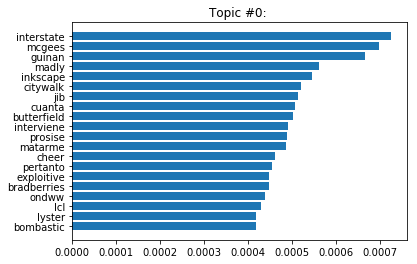

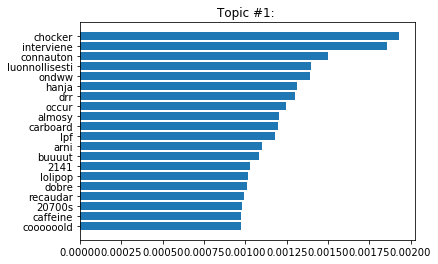

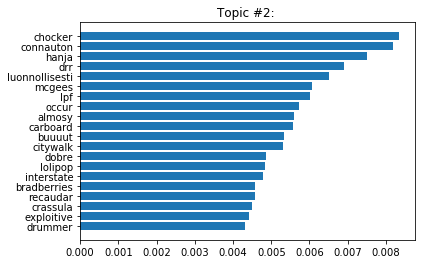

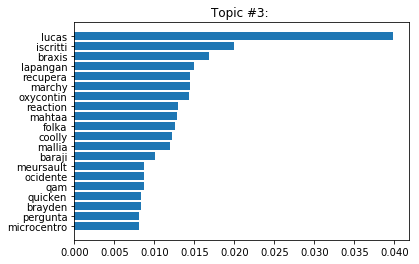

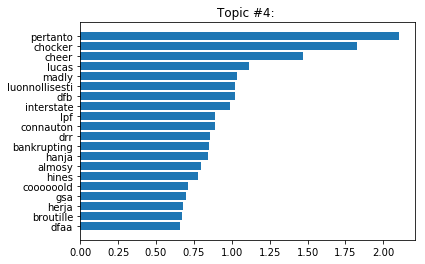

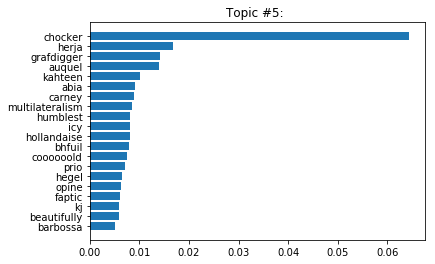

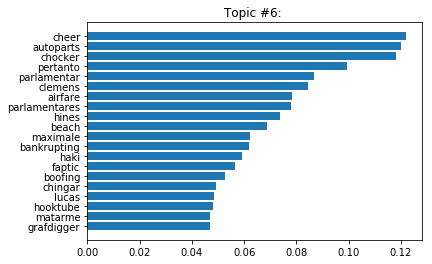

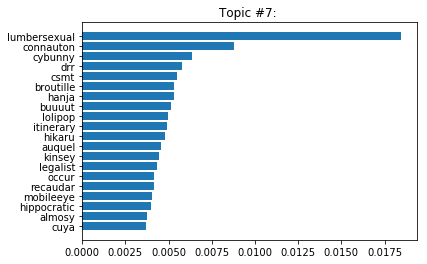

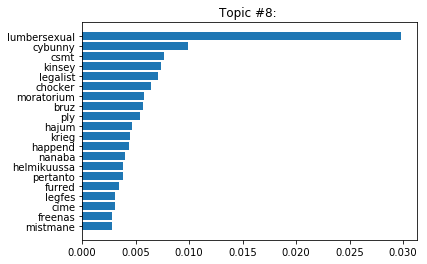

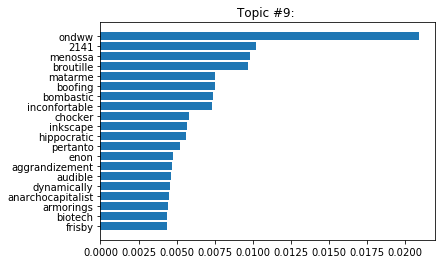


Topics in NMF model (generalized Kullback-Leibler divergence):


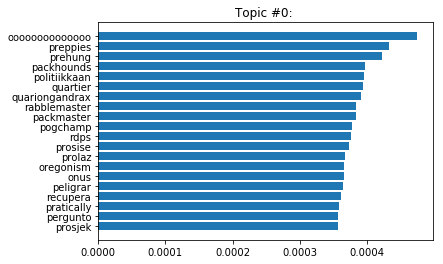

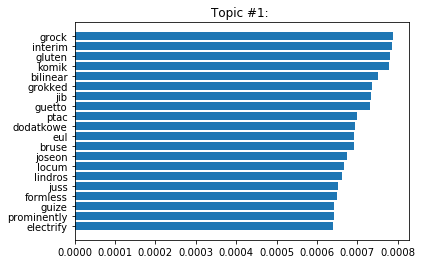

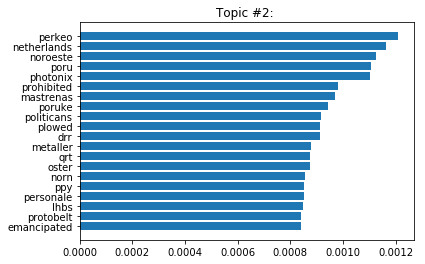

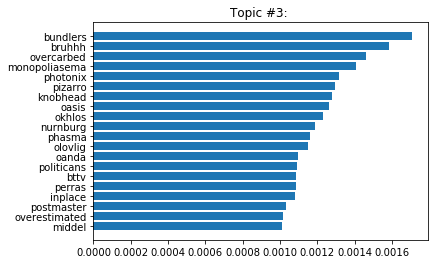

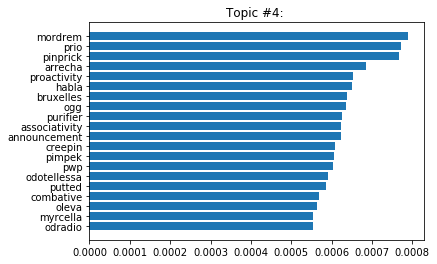

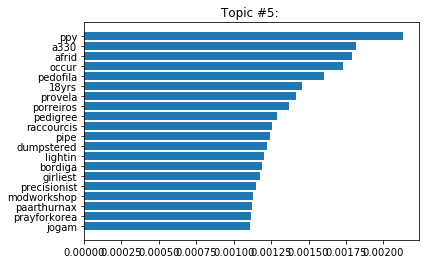

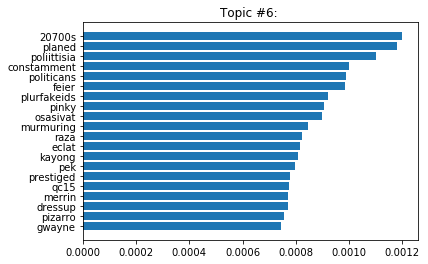

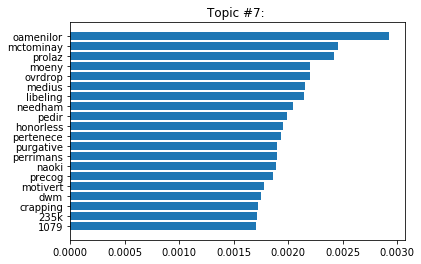

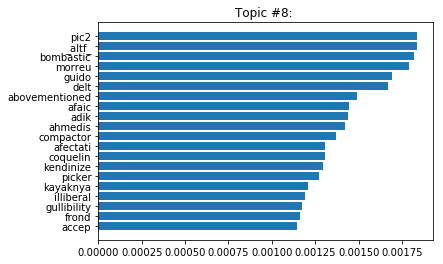

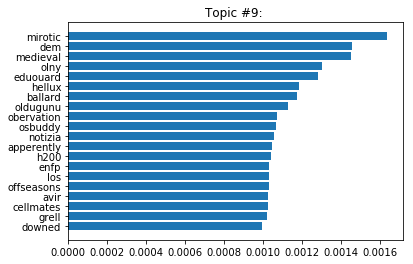


Topics in LDA model:


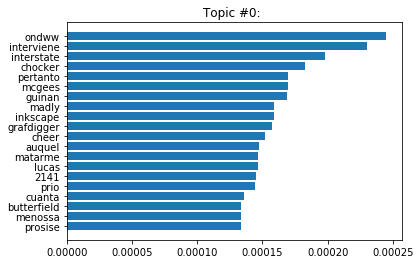

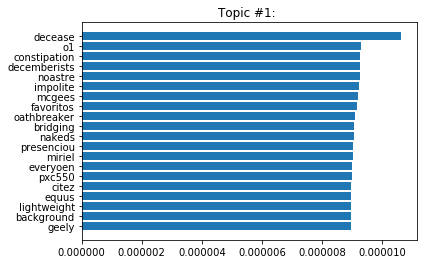

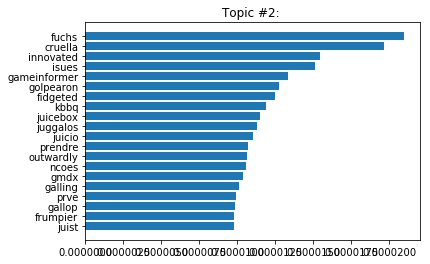

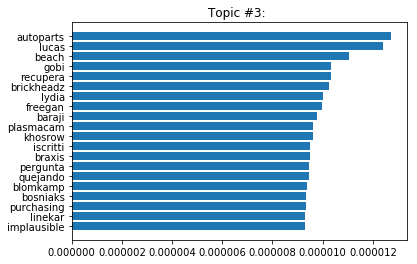

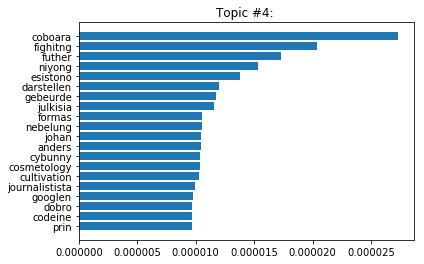

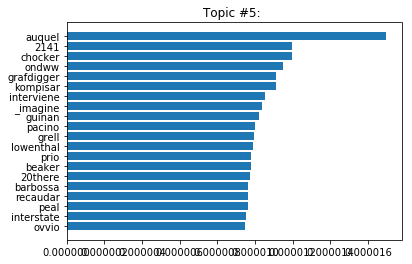

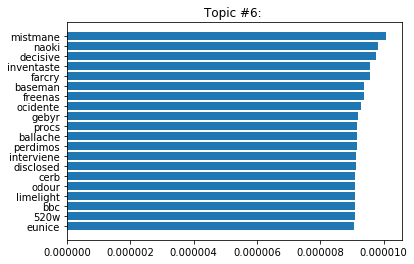

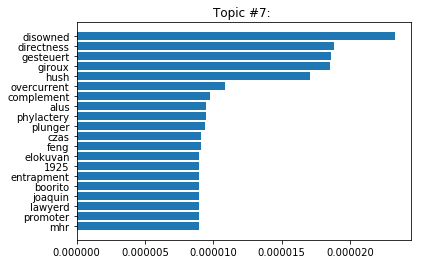

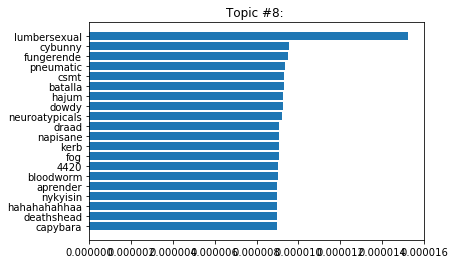

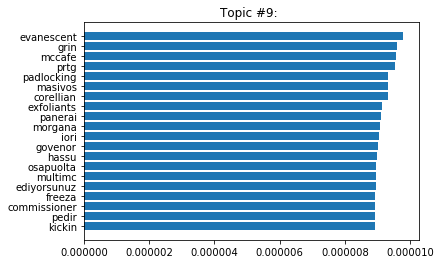

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def plot_top_words(model, feature_names, n_top_words):
    norm_comps = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    for topic_idx, topic in enumerate(norm_comps):
        x = range(n_top_words,0,-1)
        sort_idx = topic.argsort()[:-n_top_words - 1:-1]
        plt.barh(x, topic[sort_idx])
        plt.yticks(x, np.asarray(feature_names)[sort_idx])
        plt.title("Topic #%d: " % topic_idx)
        plt.show()

def show_top_wc(model, feature_names, n_top_words):
    wc = WordCloud(background_color="white", max_words=n_top_words)
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx)
        words = {}
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            words[feature_names[i]] = topic[i]
        wc.generate_from_frequencies(words)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.show()

print("\nTopics in LSA model:")
# print_top_words(LSA, feature_names, n_top_words)
plot_top_words(LSA, feature_names, n_top_words)

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
# print_top_words(pLSA, feature_names, n_top_words)
plot_top_words(pLSA, feature_names, n_top_words)

print("\nTopics in LDA model:")
# print_top_words(LDA, feature_names, n_top_words)
plot_top_words(LDA, feature_names, n_top_words)
